# 자연처리 프레임워크 및 라이브러리 설치하기

In [1]:
#  한국어 자연어 처리를 위한 형태소 분석기 패키지
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 56.6 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
# 필요 프레임워크 및 라이브러리 준비
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 로드

In [3]:
!git clone https://github.com/2runo/Curse-detection-data.git

Cloning into 'Curse-detection-data'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 16 (delta 4), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [4]:
import sys, fileinput

f1 = open('/content/Curse-detection-data/dataset.txt', 'r')
f2 = open('/content/Curse-detection-data/dataset1.txt', 'w')
for line in f1:
    f2.write(line.replace('|', '    '))
f1.close()
f2.close()

In [5]:
# 데이터셋 쪼개기, 판다스로 각 파일데이터를  train/test 변수에 바인딩
from sklearn.model_selection import train_test_split
dataset =  pd.read_table("/content/Curse-detection-data/dataset.txt",sep='|', names=['document','label'])
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=2000)

In [6]:
# 변수에 바인딩된 데이터 개수 확ㅇ니
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data))

훈련용 리뷰 개수 : 4660
테스트용 리뷰 개수 : 1165


In [7]:
# 훈련 데이터 내용 확인
train_data[:5] # 상위 5개 출력

,document,label
5753,헤드기어 어쩔때 쓰는거고 어쩔때 안쓰는거임 ㅇㅅㅇ??,0
3826,지금 연락하는 여자랑 폰섹 엄청 많이했는데만나서 호텔 들어가서침대에 서로 마주보고 ...,1
5810,도쿄 올림픽때만 응윈 깔짝하겠지 ㅠㅠ 복싱에 대한 국민인식이,0
1265,그 영화 이후로 마루타라는 신화가 생김,0
5362,다들 채식하자 ㅆㅂ 그러면서 고기를 먹는 나는 ㅠㅠ,1


In [8]:
# 테스트 데이터 내용 확인
test_data[:5] # 상위 5개 출력

,document,label
3987,너가 열심히 산 걸 그냥 타고난 거라고 폄하하는 거처럼 보일 수도 있고.,0
277,NTR 하면 된다 이기 바꿔먹으면 된다 이기,0
1042,그럼 대충 운띄워보세요 포항지열발전으로 인한 지진이라던가 cnk 사기친거같은것들,0
4962,쟤 말도 틀림. 쟤 말대로 하자면 천한직업 가진 사람도 대접을 받아야 한다는 당위 ...,0
467,사악한년,1


# 데이터 정제하기

In [9]:
# 중복 데이터 체크
train_data['document'].nunique(), train_data['label'].nunique()

(4660, 2)

In [10]:
# 중복 데이터 제거
train_data1 = train_data.copy()
train_data1.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [11]:
# 중복 샘플 제거 확인
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 4660


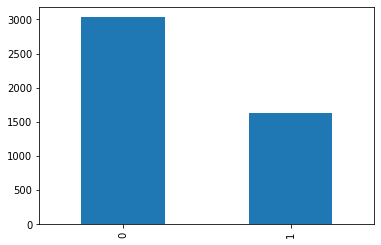

In [12]:
# 훈련 데이터에서의 레이블 값의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [13]:
# 균일해보이지만 정확하게 몇개인지 확인해보자
print(train_data.groupby('label').size().reset_index(name = 'count'))

  label  count
0     0   3030
1     1   1630


In [14]:
# 0이 근소하게 많음, Null값이 있는지 체크해보자
print(train_data.isnull().values.any())

False


In [15]:
# 어느 열에 null값이 존재하는지 확인
print(train_data.isnull().sum())

document    0
label       0
dtype: int64


In [16]:
# null값 데이터가 어느 인덱스 위치에 존재하는지 출력
train_data.loc[train_data.document.isnull()]

,document,label


In [17]:
# Null 값 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [18]:
# null데이터 제거된 샘플 개수 확인
print(len(train_data))

4660


# 전처리 해보자

In [19]:
# 훈련데이터에 한글과 공백을 제외하고 모두 제거해보자
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,document,label
5753,헤드기어 어쩔때 쓰는거고 어쩔때 안쓰는거임 ㅇㅅㅇ,0
3826,지금 연락하는 여자랑 폰섹 엄청 많이했는데만나서 호텔 들어가서침대에 서로 마주보고 ...,1
5810,도쿄 올림픽때만 응윈 깔짝하겠지 ㅠㅠ 복싱에 대한 국민인식이,0
1265,그 영화 이후로 마루타라는 신화가 생김,0
5362,다들 채식하자 ㅆㅂ 그러면서 고기를 먹는 나는 ㅠㅠ,1


In [20]:
# 공백 데이터를 null값으로 변경
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

document    24
label        0
dtype: int64


In [21]:
# null값 행 출력
train_data.loc[train_data.document.isnull()][:5]

,document,label
23,NaN,0
4778,NaN,0
4708,NaN,0
972,NaN,0
1755,NaN,0


In [22]:
# null값 데이터 제거
train_data = train_data.dropna(how = 'any')
print(len(train_data))

4636


  label  count
0     0   3006
1     1   1630


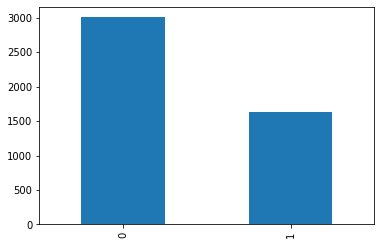

In [23]:
# 분포 체크
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [24]:
# test데이터에도 전처리 과정 진행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 1158


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

# 토큰화

In [25]:
# 불용어 정의 (한국어 조사, 접속사 등)
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [26]:
# 형태소 분석기 연습해보기 (KoNLPy의 Okt)
okt = Okt()

In [27]:
# 훈련데이터에 형태소 분석기를 사용하여 토큰화를 하면서 불용어 제거
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [28]:
print(X_train[:3])

[['헤드기어', '어쩔', '때', '쓰다', '어쩔', '때', '안', '쓰다', '임', 'ㅇㅅㅇ'], ['지금', '연락', '여자', '랑', '폰섹', '엄청', '많이', '만나다', '호텔', '들어가다', '침대', '서로', '마주', '보고', '앉다', '다음', '핸드폰', '잡고', '서로', '쳐다보다', '폰섹', '하자', '고', '더니', '아', '엄청', '부끄럽다', 'ㅎㅎㅎㅎ', '좋아하다', '또', '야하다', '거', '뭐', '있다', '무선', '바이브레이터', '같다', '사서', '끼', '고', '밖에', '나가다', '해보다'], ['도쿄', '올림픽', '때', '만', '응윈', '깔다', '짝', 'ㅠㅠ', '복싱', '대한', '국민', '인', '식이']]


In [29]:
X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [30]:
print(X_test[:3])

[['너', '열심히', '산', '걸', '그냥', '타고나다', '거', '라고', '펴다', '거', '처럼', '보이다', '수도', '있다'], ['되다', '이기', '바꾸다', '먹다', '되다', '이기'], ['그렇다', '대충', '운', '띄우다', '보다', '포항', '지열발전', '인하다', '지진', '라던가', '사기', '치다', '같다', '들다']]


# 정수 인코딩

In [31]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 데이터를 정수로 변환
# 일단 단어 집합을 만들자
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [32]:
print(tokenizer.word_index)

{'있다': 1, '을': 2, '보다': 3, '아니다': 4, '되다': 5, '없다': 6, '새끼': 7, '다': 8, '같다': 9, '로': 10, '에서': 11, '안': 12, 'ㅋㅋ': 13, '아': 14, '못': 15, '고': 16, '저': 17, '이다': 18, '만': 19, '그렇다': 20, '나': 21, '말': 22, '그': 23, 'ㅋㅋㅋ': 24, '사람': 25, '임': 26, '거': 27, '먹다': 28, '존나': 29, '년': 30, '니': 31, '내': 32, '개': 33, '게': 34, '생각': 35, '가다': 36, '때': 37, '맞다': 38, '적': 39, '들다': 40, '면': 41, '병신': 42, '네': 43, '하고': 44, '진짜': 45, '그냥': 46, '돈': 47, '야': 48, '뭐': 49, '일': 50, '좋다': 51, '인': 52, '더': 53, '지': 54, '인데': 55, '받다': 56, '왜': 57, '치다': 58, '알다': 59, '애': 60, '라': 61, '오다': 62, '용접': 63, '나오다': 64, '많다': 65, '한테': 66, '것': 67, '않다': 68, '놈': 69, '기': 70, '이나': 71, '지다': 72, '근데': 73, '너': 74, '글': 75, '사': 76, '서': 77, '씨발': 78, '함': 79, '모르다': 80, '좆': 81, 'ㅋㅋㅋㅋ': 82, '한국': 83, '일본': 84, '하': 85, '지금': 86, '정도': 87, '나다': 88, '까지': 89, '소리': 90, '이냐': 91, '여자': 92, '수': 93, '나라': 94, '냐': 95, '지랄': 96, '주다': 97, '살다': 98, '랑': 99, '일베': 100, '많이': 101, '공부': 102, '시발': 103, 'ㅋ': 104, '이지

In [33]:
# vocab 저장
vocab = tokenizer.word_index
import json
json = json.dumps(vocab, ensure_ascii=False)
vacab = open("Slang_RNN-LSTM_KoNLPy(Okt)_Data(2runo)_indexed_vocab_v1.0.json", "w", encoding="utf-8")
#json.dump(train_docs, make_file,, indent="\t")
vacab.write(json)
vacab.close()

In [34]:
# 등장 빈도수가 낮은 데이터를 처리해보자
# 2회 미만 단어는 비중이 몇인지 체크
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 9542
등장 빈도가 1번 이하인 희귀 단어의 수: 5197
단어 집합에서 희귀 단어의 비율: 54.46447285684343
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 10.47317721978155


In [35]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4346


In [36]:
# 단어집합을 케라스 토크나이저의 인자로 넘겨주면, 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [37]:
print(X_train[:3])

[[964, 37, 108, 964, 37, 12, 108, 26, 2164], [86, 846, 92, 99, 2869, 523, 101, 377, 2870, 188, 847, 122, 418, 199, 1724, 1236, 847, 1442, 2869, 1725, 16, 1726, 14, 523, 1237, 1443, 163, 140, 203, 27, 49, 1, 2165, 2871, 9, 1727, 524, 16, 248, 174, 126], [2872, 1086, 37, 19, 320, 848, 279, 440, 597, 396, 52, 2873]]


In [38]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

# 빈 샘플(empty samples)제거

In [39]:
# 각 샘플의 길이가 0인 샘플들의 인덱스 확인
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [40]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

4551
4551


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

리뷰의 최대 길이 : 360
리뷰의 평균 길이 : 9.761590859151834


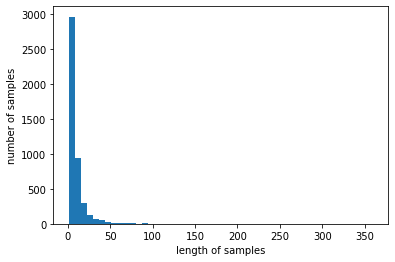

In [41]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰는 작업
# 전체 데이터에서 가장 길이가 긴 리뷰와, 전체의 길이분포를 알아보자
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [42]:
# 최적의 길이를 찾기 위해, 전체 샘플중 길이가 max_len 이하인 샘플의 비율을 확인하는 함수 생성
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [43]:
# 30 이하 비율 체크
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.38562953197099


In [44]:
# 95%가 30이하 이므로 모든 샘플길이를 30으로 결정
# 짧은 데이터는 0을 채우고, 30을 넘는 긴 데이터는 손실됨
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# LSTM으로 네이버 영화 리뷰 감성 분류하기

In [45]:
# 필요한 프레임워크 및 라이브러리 임포트
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [46]:
# 필요한 매트릭 선언, AUC-ROC, F1-Score, AUC-PR 에 필요한 지표 모두 체크
import tensorflow as tf
ROCauc = tf.keras.metrics.AUC(curve="ROC") # auc_1
PRauc = tf.keras.metrics.AUC(curve="PR") # auc_2
# RECALL = tf.keras.metrics.Recall()
# PRECISION = tf.keras.metrics.Precision()
TP = tf.keras.metrics.TruePositives()
TN = tf.keras.metrics.TrueNegatives()
FP = tf.keras.metrics.FalsePositives()
FN = tf.keras.metrics.FalseNegatives()

In [47]:
# 임베딩 벡터의 차원은 100으로, 리뷰분류를 위해 LSTM 사용
# 왜 100인지는 모름
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [48]:
# 검증 데이터 손실이 4회 증가하면 학습 조기 종료
# model check point를 사용하여 검증 데이터의 정확도가 이전보다 좋아질 경우만 모델 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('Slang_RNN-LSTM_KoNLPy(Okt)_Data(2runo)_model_v1.0.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [49]:
# 에포크 15번 수행, 훈련데이터중 20%를 검증데이터로 사용하며 정확도 체크
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, TP, TN, FP, FN])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=100)

Epoch 1/15


UnimplementedError: ignored

In [ ]:
# 테스트 데이터에서 정확도 측정
loaded_model = load_model('Slang_RNN-LSTM_KoNLPy(Okt)_Data(2runo)_model_v1.0.h5')
print("\n 테스트 결과", loaded_model.evaluate(X_test, y_test))

# 비속어 예측하기

In [ ]:
# 학습한 모델에 새로운 예측값을 얻는 것은 model.predict() 사용
# 그리고 예측할 때에도 동일한 전처리 수행해야함.
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 비속어가 포함된 문장입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 비속어가 포함되지 않은 문장입니다..\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

In [ ]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

In [ ]:
sentiment_predict('감독 뭐하는 놈이냐?')

In [ ]:
sentiment_predict('감독 뭐하시는 분인지?')

In [ ]:
sentiment_predict('대박 감독 뭐하시는 분?')

In [ ]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

In [ ]:
sentiment_predict('개 새끼 씨발')

In [ ]:
sentiment_predict('애미는 있냐? 개같은 놈이네')
sentiment_predict('니 창자로 젓갈 담궈 버린다')
sentiment_predict('눈깔의 위치를 바꿔줘?')
sentiment_predict('ㅅ1바라 뒤질래?')
sentiment_predict('애미 뒤진 새끼')
sentiment_predict('밥쳐먹고 그것만 하는 새끼가')
sentiment_predict('존나 못하네 진짜 쳐 나가라')